# Test significance of S1, S2, D1, D2
The idea is to follow the procedure of the paper "Assessing harmfulness and vulnerability in global bipartite networks of
terrorist-target relationships" A. Spelta et al.

In [1]:
import sys

sys.path.insert(0, "../")

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.hid_haus import hid_hous
from scripts.get_graph import get_graph

## Get Adjacency matrix and graph

In [2]:
# Get the adjacency matrix from the data
adjacency_matrix = pd.read_csv("../../dataset/large_adjacency_matrix.csv", compression='gzip').values

graph = get_graph(adjacency_matrix)

## Null Model Construction (Level-1)


In [3]:
# Define a function to generate random graphs while preserving degrees
def generate_null_model(bipartite_graph):
    # Get the degree sequences for both bipartite sets
    top_nodes, bottom_nodes = nx.bipartite.sets(bipartite_graph)
    
    top_degrees = bipartite_graph.degree(top_nodes)
    top_degrees = [degree for _, degree in top_degrees]
    
    bottom_degrees = bipartite_graph.degree(bottom_nodes)
    bottom_degrees = [degree for _, degree in bottom_degrees]

    # Create configuration model
    config_model = nx.bipartite.configuration_model(top_degrees, bottom_degrees)
    return nx.Graph(config_model)


# Create an ensemble of random networks
num_null_models = 5000
null_models = [generate_null_model(graph) for _ in range(num_null_models)]

## Statistical Validation:


### Compute the Z-score

In [4]:
# Compute the same measures for each null model
null_model_measures = [hid_hous(nx.adjacency_matrix(null_model), 2) for null_model in null_models]


# Calculate Z-scores for statistical significance
def calculate_z_score(real_value, null_model_values):
    mean_null = np.mean(null_model_values)
    std_null = np.std(null_model_values)
    z_score = (real_value - mean_null) / std_null
    return z_score

[real_kd, real_ks] = hid_hous(adjacency_matrix, 2)

# Compute Z-scores for your measures
z_score_kd = calculate_z_score(real_kd, [kd for kd, _ in null_model_measures])
z_score_ks = calculate_z_score(real_ks, [ks for _, ks in null_model_measures])


### Create a dataframe containing all metrics

In [6]:
disease_df = pd.read_csv("../../dataset/diseases.csv")

disease_df["L1 Z-score"] = z_score_kd[:, 0].tolist()
disease_df["L2 Z-score"] = z_score_kd[:, 1].tolist()


symptoms_df = pd.read_csv("../../dataset/symptoms.csv")
symptoms_df=symptoms_df[symptoms_df["symptom"]!="Disease"]
print("df length", len(symptoms_df))
print("z_score length", len(z_score_ks))
symptoms_df["L1 Z-score"] = z_score_ks[:, 0].tolist()
symptoms_df["L2 Z-score"] = z_score_ks[:, 1].tolist()

df length 325
z_score length 325


### Store the dataframes

In [7]:
symptoms_df.to_csv("../../dataset/symptoms_z_score.csv", compression='gzip')
disease_df.to_csv("../../dataset/diseases_z_score.csv", compression='gzip')

## Visualize the z-score

### Load data

In [8]:
symptoms_df = pd.read_csv("../../dataset/symptoms_z_score.csv", compression='gzip')
disease_df = pd.read_csv("../../dataset/diseases_z_score.csv", compression='gzip')

### L1

<Axes: title={'center': 'Z-score of L1 for Symptoms'}, xlabel='symptom', ylabel='Z-score'>

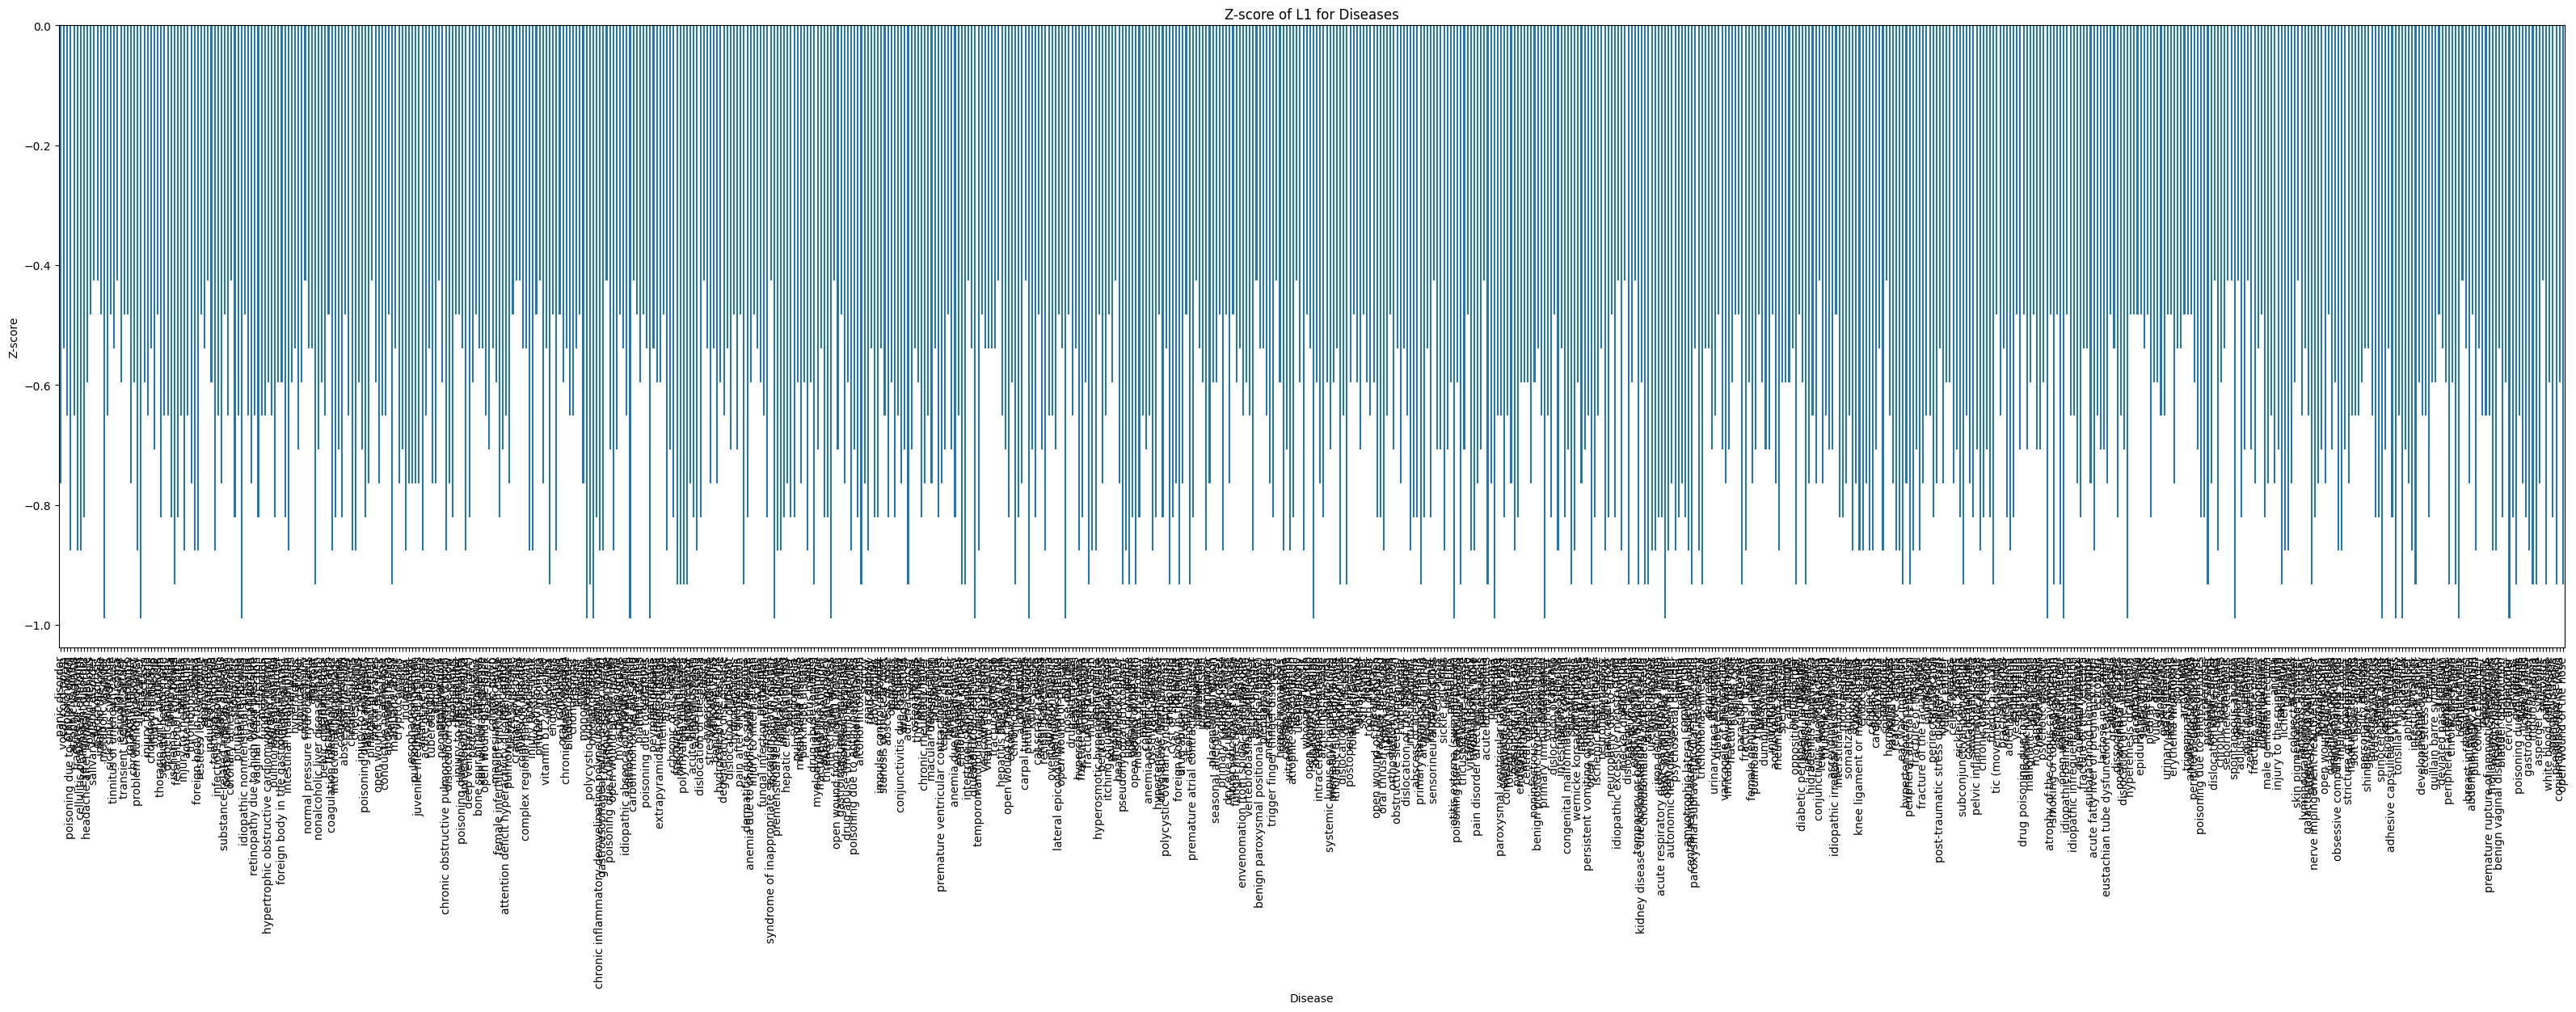

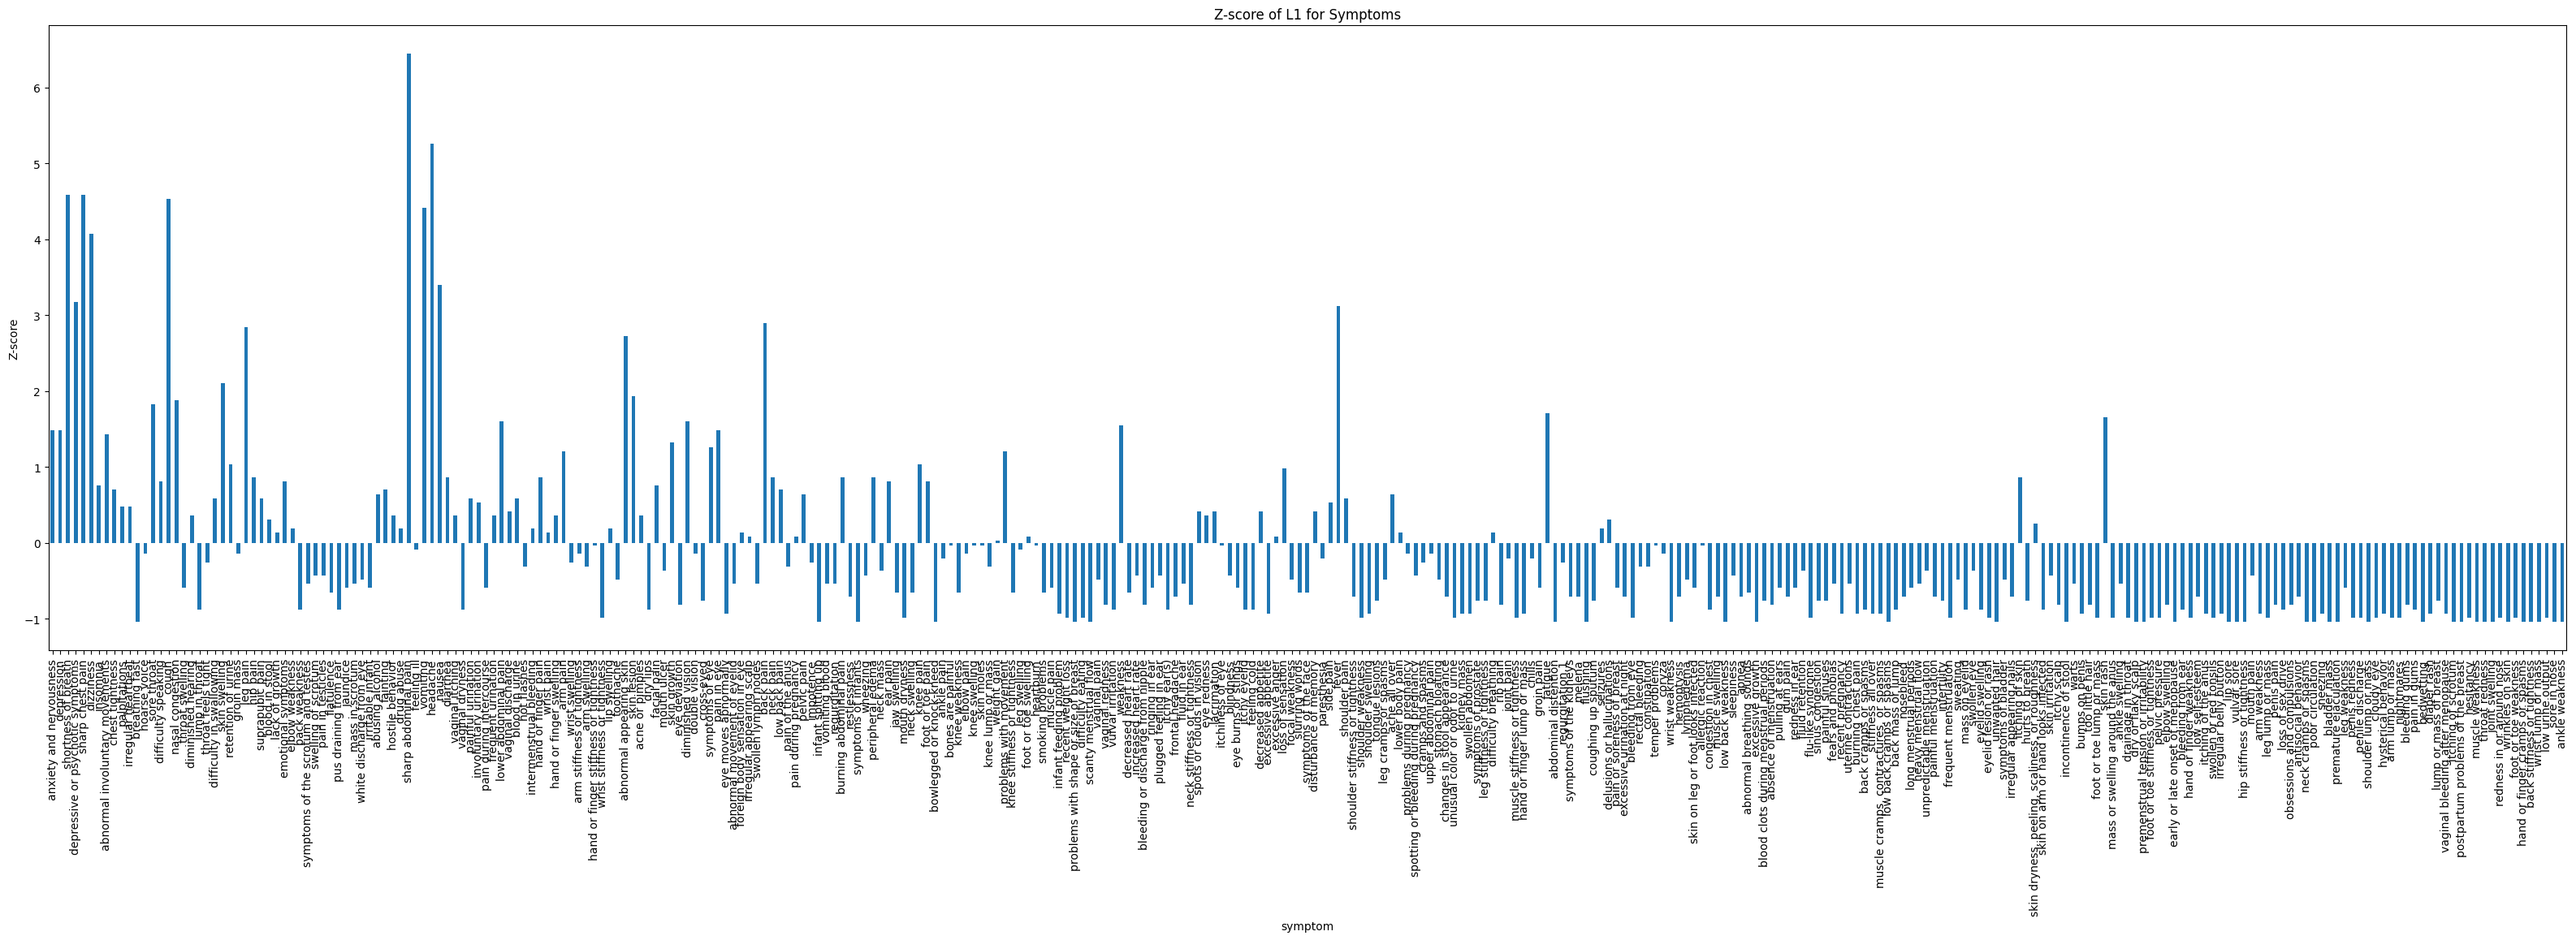

In [9]:
disease_df.plot.bar(
    x="Disease",
    y=["L1 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Diseases",
)


symptoms_df.plot.bar(
    x="symptom",
    y=["L1 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Symptoms",
)

### L2

<Axes: title={'center': 'Z-score of L2 for Symptoms'}, xlabel='symptom', ylabel='Z-score'>

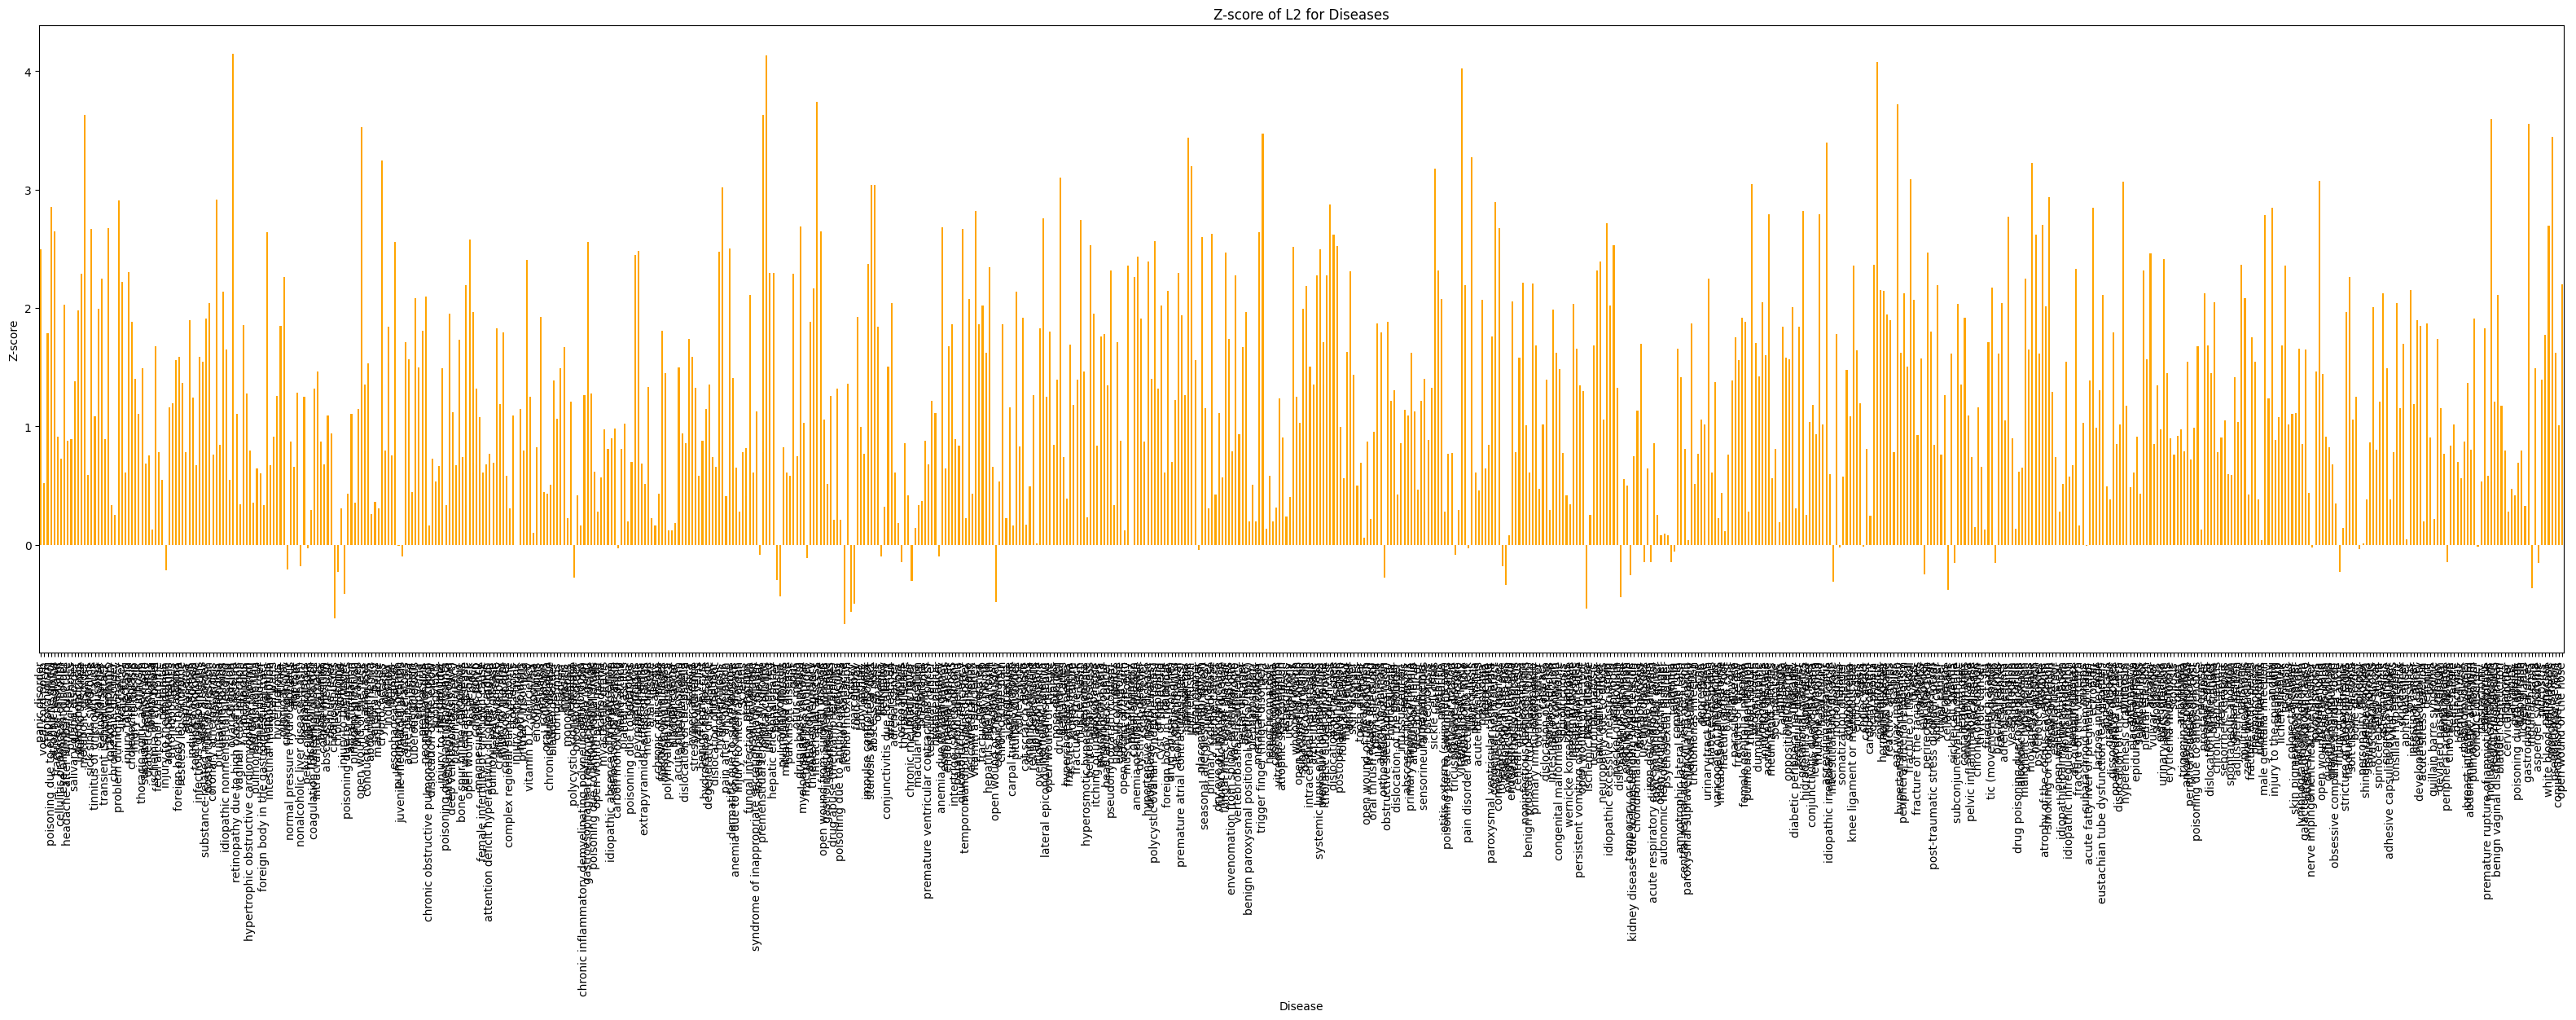

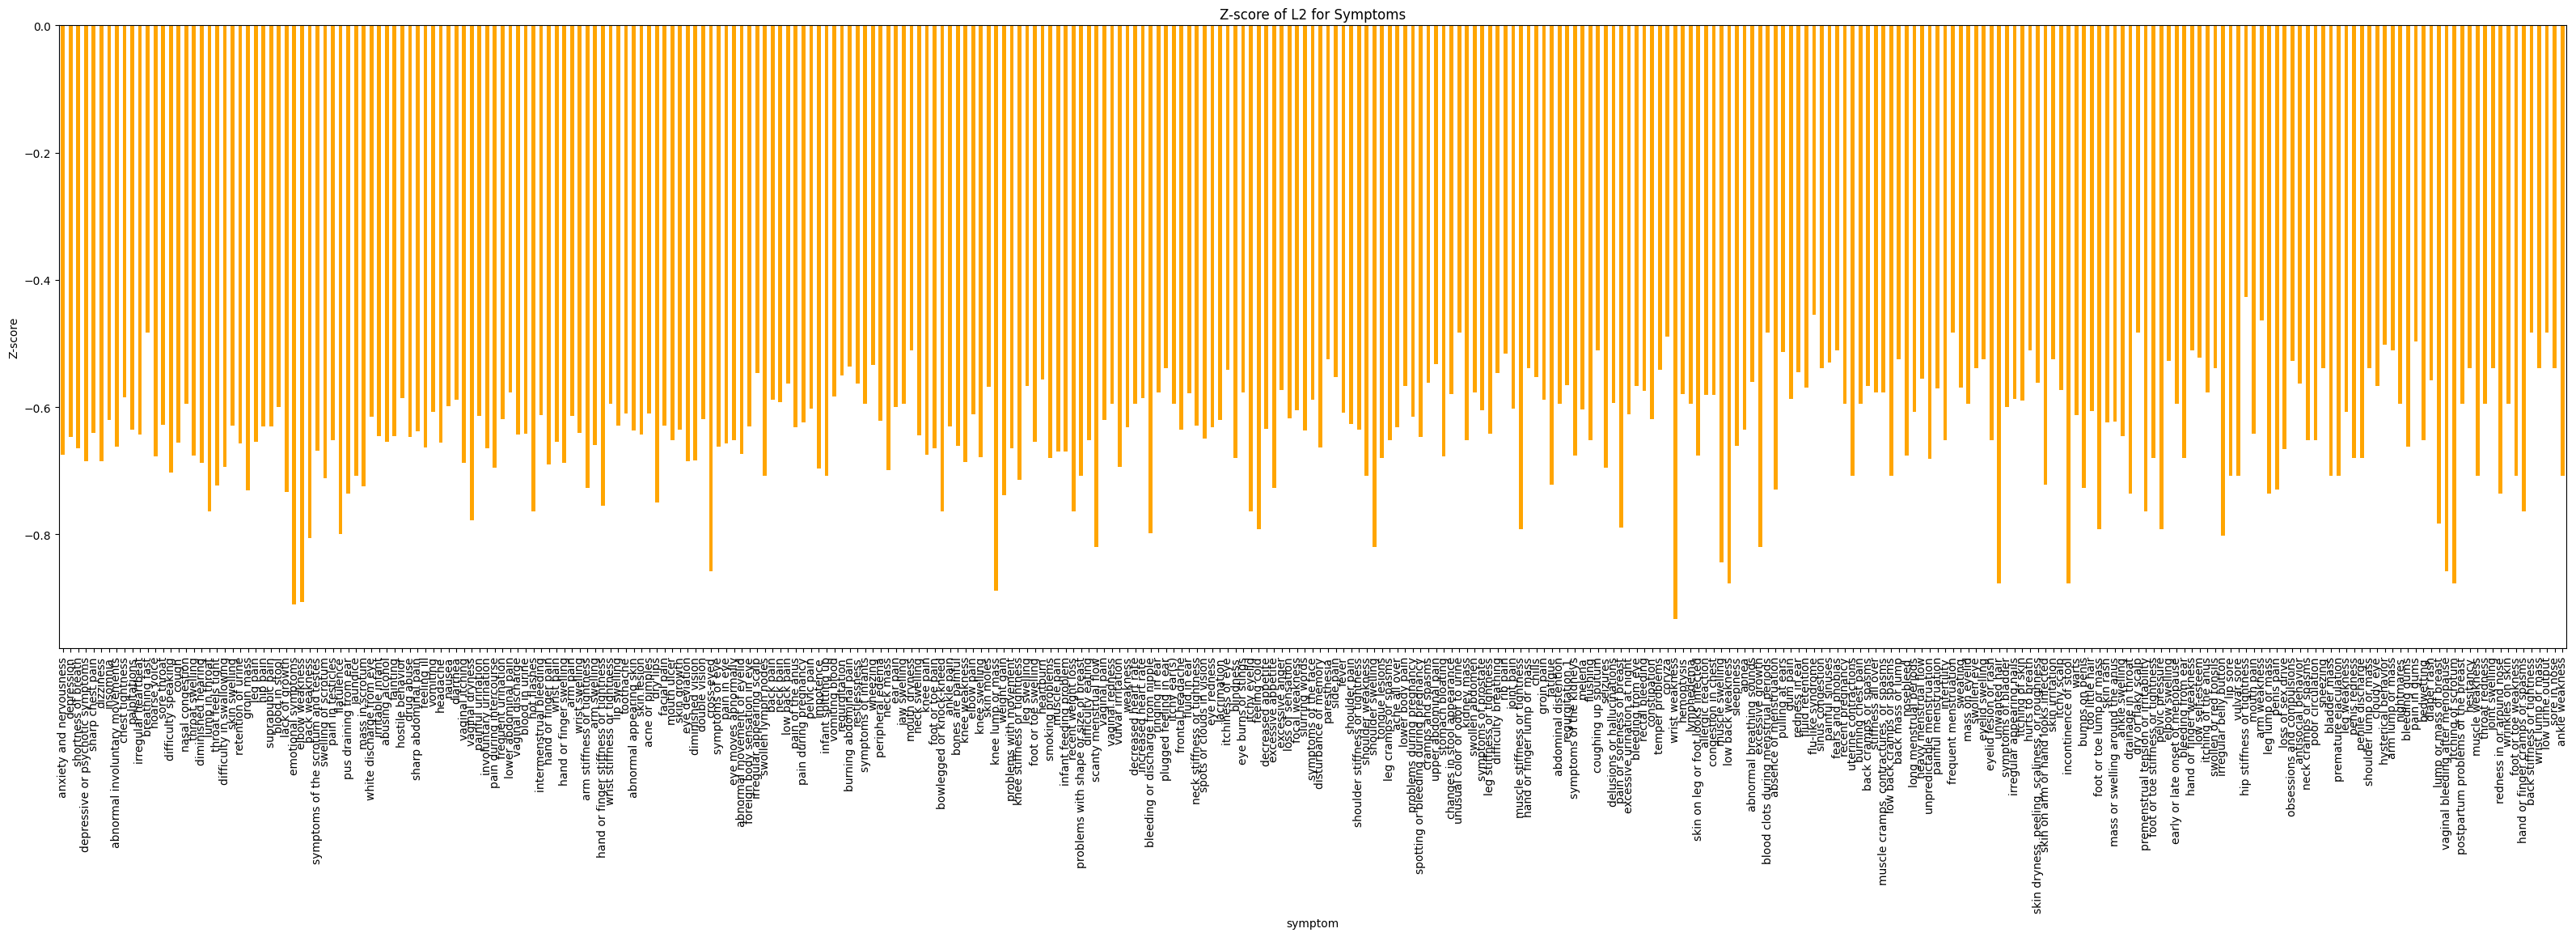

In [10]:
disease_df.plot.bar(
    x="Disease",
    y=["L2 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Diseases",
    color="orange",
)


symptoms_df.plot.bar(
    x="symptom",
    y=["L2 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Symptoms",
    color="orange",
)

## Plot PDF

### Level 1

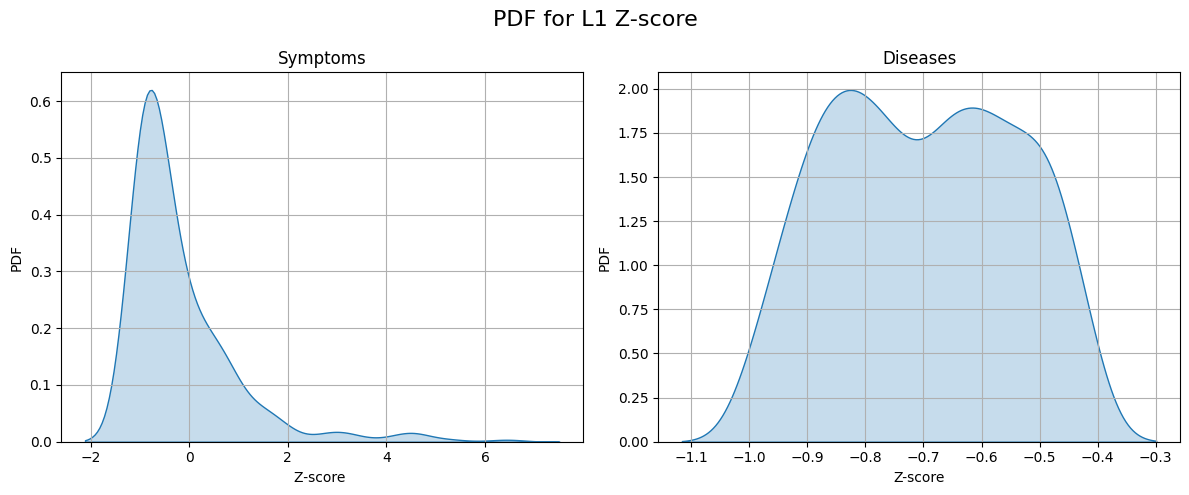

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'metric1' and 'metric2' are the columns you want to plot
metric1_values = symptoms_df["L1 Z-score"]
metric2_values = disease_df["L1 Z-score"]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("PDF for L1 Z-score", fontsize=16)


# Plot the PDF for Metric 1
plt.title("PDF of L1 Z-scores ")
sns.kdeplot(metric1_values, fill=True, ax=axes[0])
axes[0].set_title("Symptoms")
axes[0].set_xlabel("Z-score ")
axes[0].set_ylabel("PDF")
axes[0].grid()

# Plot the PDF for Metric 2
sns.kdeplot(metric2_values, fill=True, ax=axes[1])
axes[1].set_title("Diseases")
axes[1].set_xlabel("Z-score")
axes[1].set_ylabel("PDF")
axes[1].grid()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Level 2

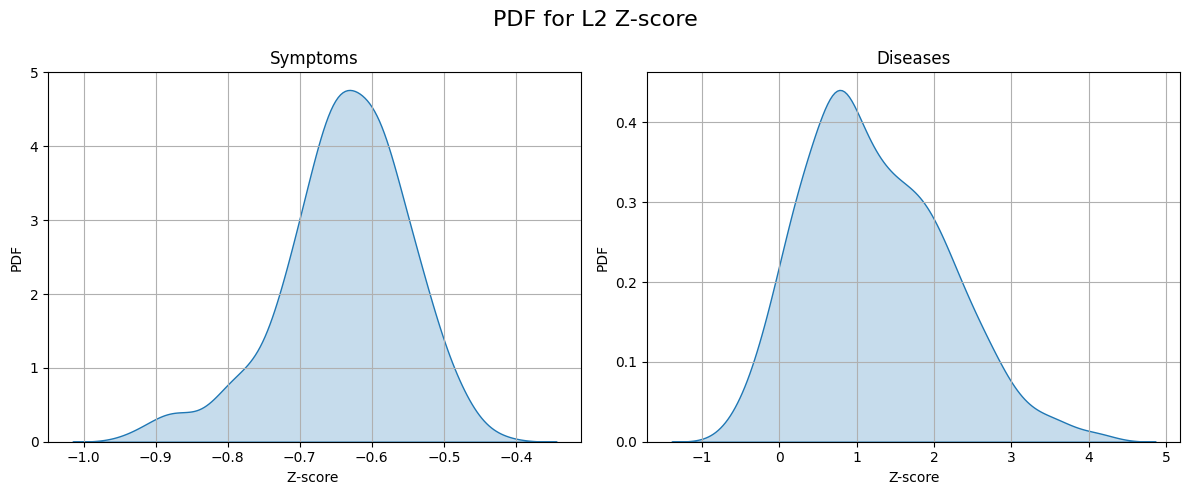

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'metric1' and 'metric2' are the columns you want to plot
metric1_values = symptoms_df["L2 Z-score"]
metric2_values = disease_df["L2 Z-score"]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("PDF for L2 Z-score", fontsize=16)

# Plot the PDF for Metric 1
sns.kdeplot(metric1_values, fill=True, ax=axes[0])
axes[0].set_title("Symptoms")
axes[0].set_xlabel("Z-score ")
axes[0].set_ylabel("PDF")
axes[0].grid()

# Plot the PDF for Metric 2
sns.kdeplot(metric2_values, fill=True, ax=axes[1])
axes[1].set_title("Diseases")
axes[1].set_xlabel("Z-score")
axes[1].set_ylabel("PDF")
axes[1].grid()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()